## Thought experiment

First we create random term frequencies for a corpus that consists of only 6 terms.

In [65]:
import numpy as np

topic = {}

tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), np.random.rand(6))))
tfidf

{'cat': 0.9298225968652644,
 'dog': 0.26865106663512706,
 'apple': 0.1867230475455367,
 'lion': 0.2798160311867057,
 'NYC': 0.15104408556378512,
 'love': 0.3068210901976337}

We want to teach the machine how to recognize topics based on term frequencies of the corpus. An example of how a topic vector would look like is shown below:

In [66]:
topic['petness'] = (.3 * tfidf['cat'] +
                    .3 * tfidf['dog'] +
                    0 * tfidf['apple'] +
                    0 * tfidf['lion'] +
                    .2 * tfidf['NYC'] +
                    .2 * tfidf['love'])  # #2

topic['animalness'] = (.1 * tfidf['cat'] +
                       .3 * tfidf['dog'] +
                       .1 * tfidf['apple'] +
                       .5 * tfidf['lion'] +
                       .1 * tfidf['NYC'] +
                       .1 * tfidf['love'])

topic['cityness'] = (.0 * tfidf['cat'] +
                     .1 * tfidf['dog'] +
                     .2 * tfidf['apple'] +
                     .1 * tfidf['lion'] +
                     .5 * tfidf['NYC'] +
                     .1 * tfidf['love'])
topic

{'petness': 0.4511151342024012,
 'animalness': 0.37794441760111297,
 'cityness': 0.19839547109294656}

The relationships between words and topics can be flipped. If we treat "petness", "animalness", and "cityness" as 3 dimensions, we can create a 3 x 6 matrix.

In [67]:
word_vector = {}

word_vector['cat'] = .3*topic['petness'] + \
                     .1*topic['animalness'] + \
                     0*topic['cityness']

word_vector['dog'] = .3*topic['petness'] + \
                     .1*topic['animalness'] + \
                     .1*topic['cityness']

word_vector['apple'] = 0*topic['petness'] + \
                       .1*topic['animalness'] + \
                       .2*topic['cityness']

word_vector['lion'] = 0*topic['petness'] + \
                      .5*topic['animalness'] + \
                      .1*topic['cityness']

word_vector['NYC'] = .2*topic['petness'] + \
                     .1*topic['animalness'] + \
                     .5*topic['cityness']

word_vector['love'] = .2*topic['petness'] + \
                      .1*topic['animalness'] + \
                      .1*topic['cityness']

In [68]:
word_vector

{'cat': 0.17312898202083163,
 'dog': 0.1929685291301263,
 'apple': 0.0774735359787006,
 'lion': 0.20881175590985113,
 'NYC': 0.2272152041470648,
 'love': 0.14785701570988619}

## Toxic comments

In [69]:
import pandas as pd

url = 'https://gitlab.com/tangibleai/nlpia/-/raw/master/src/nlpia/data/toxic_comment_small.csv'

comments = pd.read_csv(url)
comments.head()

,text,toxic
0,you have yet to identify where my edits violat...,0
1,"""\n as i have already said,wp:rfc or wp:ani. (...",0
2,your vote on wikiquote simple english when it ...,0
3,your stalking of my edits i've opened a thread...,0
4,straight from the smear site itself. the perso...,1


In [70]:
index = ['comment{}{}'.format(i, '!'*j) for i, j in zip(range(len(comments)), comments.toxic)]

comments = pd.DataFrame(comments.values, columns=comments.columns, index=index)
mask = comments.toxic.astype(bool).values

comments['toxic'] = comments.toxic.astype(int)

print('Number of comments:', len(comments))
print('Number of toxic comments:', comments.toxic.sum())
comments.head()

Number of comments: 5000
Number of toxic comments: 650


,text,toxic
comment0,you have yet to identify where my edits violat...,0
comment1,"""\n as i have already said,wp:rfc or wp:ani. (...",0
comment2,your vote on wikiquote simple english when it ...,0
comment3,your stalking of my edits i've opened a thread...,0
comment4!,straight from the smear site itself. the perso...,1


Try solving with TF-IDF.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

nlp = spacy.load('en_core_web_sm')

def spacy_tokenize(sentence):
    return [word.text for word in nlp(sentence.lower())]

In [72]:
tfidf_model = TfidfVectorizer(tokenizer=spacy_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=comments.text).toarray()
tfidf_docs.shape

/Users/hieu/miniconda3/envs/nlpia39/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5000, 19160)

The spaCy tokenizer gave you 19,169 words in your vocabulary. You have almost 4 times as many words as you have messages. And you have almost 30 times as many words as toxic comments. So your model will not have a lot of information about the words that will indicate whether a comment is toxic or not.

## Latent Discriminant Analysis (LDA)

In [73]:
mask = comments.toxic.astype(bool).values
toxic_centroid = tfidf_docs[mask].mean(axis=0)
nontoxic_centroid = tfidf_docs[~mask].mean(axis=0)

print('toxic_centroid:', toxic_centroid)
print('nontoxic_centroid:', nontoxic_centroid)

toxic_centroid: [0.01406157 0.00363202 0.         ... 0.         0.         0.        ]
nontoxic_centroid: [1.89710535e-02 4.58793799e-03 2.57451586e-04 ... 2.47852092e-05
 1.78452160e-05 6.71831573e-05]


In [74]:
centroid_axis = toxic_centroid - nontoxic_centroid
toxicity_score = tfidf_docs.dot(centroid_axis)
toxicity_score.round(3)

array([-0.008, -0.022, -0.014, ..., -0.025, -0.001, -0.022])

In [75]:
from sklearn.preprocessing import MinMaxScaler

comments['manual_score'] = MinMaxScaler().fit_transform(toxicity_score.reshape(-1, 1))
comments['manual_predict'] = (comments.manual_score > .5).astype(int)
comments['toxic manual_predict manual_score'.split()].round(2)

,toxic,manual_predict,manual_score
comment0,0,0,0.41
comment1,0,0,0.27
comment2,0,0,0.35
comment3,0,0,0.47
comment4!,1,0,0.48
...,...,...,...
comment4995,0,0,0.22
comment4996,0,0,0.36
comment4997!,1,0,0.25
comment4998!,1,0,0.48


In [76]:
correct_predictions = (1 - (comments.toxic - comments.manual_predict).abs()).sum() / len(comments)
correct_predictions

0.8944

89.5% of predictions are correc tusing an "approximate" version of LDA. Let's see the result with a "full" LDA.

In [77]:
from sklearn import discriminant_analysis
lda_tfidf = discriminant_analysis.LinearDiscriminantAnalysis()

lda_tfidf = lda_tfidf.fit(tfidf_docs, comments.toxic)

In [78]:
comments['lda_predict'] = lda_tfidf.predict(tfidf_docs)
comments['lda_predict']

comment0        0
comment1        0
comment2        0
comment3        0
comment4!       1
               ..
comment4995     0
comment4996     0
comment4997!    1
comment4998!    1
comment4999     0
Name: lda_predict, Length: 5000, dtype: int64

In [79]:
lda_tfidf.score(tfidf_docs, comments.toxic)

0.9992

We have 99.92% correct, which is better but this is because we didn't split the docs into train set and test set, which could have resulted in overfitting.

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_docs, comments.toxic, test_size=0.2)
lda_tfidf = discriminant_analysis.LinearDiscriminantAnalysis(n_components=1)
lda = lda_tfidf.fit(X_train, y_train)
round(float(lda.score(X_train, y_train)), 3), round(float(lda.score(X_test, y_test)), 3)

(0.999, 0.585)

The test set has significantly lower accuracy than the train set. Topic modeling can help solve this problem. It allows you to generalize the models from a small training set, so that it still works well on messages using different combinations of words.

### Confusion matrix

The confusion matrix will tell you the number of times the model made a mistake. There are two kinds of mistakes, false positive mistakes and false negative mistakes.

In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lda.predict(X_test))

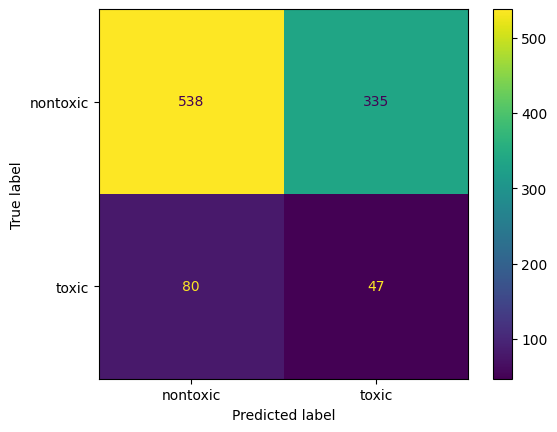

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=['nontoxic', 'toxic'])
disp.plot()

## PCA

In [83]:
import pandas as pd
from sklearn.decomposition import PCA
import seaborn

from matplotlib import pyplot as plt

url = 'https://gitlab.com/tangibleai/nlpia/-/raw/master/src/nlpia/data/pointcloud.csv.gz'
df = pd.read_csv(url, index_col=0)
df.head()

,x,y,z
0,0.000403,-0.062019,-0.005498
1,-0.002863,-0.060056,-0.009567
2,-0.001945,-0.041256,-0.001349
3,-0.001867,-0.042348,-0.001900
4,0.002323,-0.061789,-0.003647


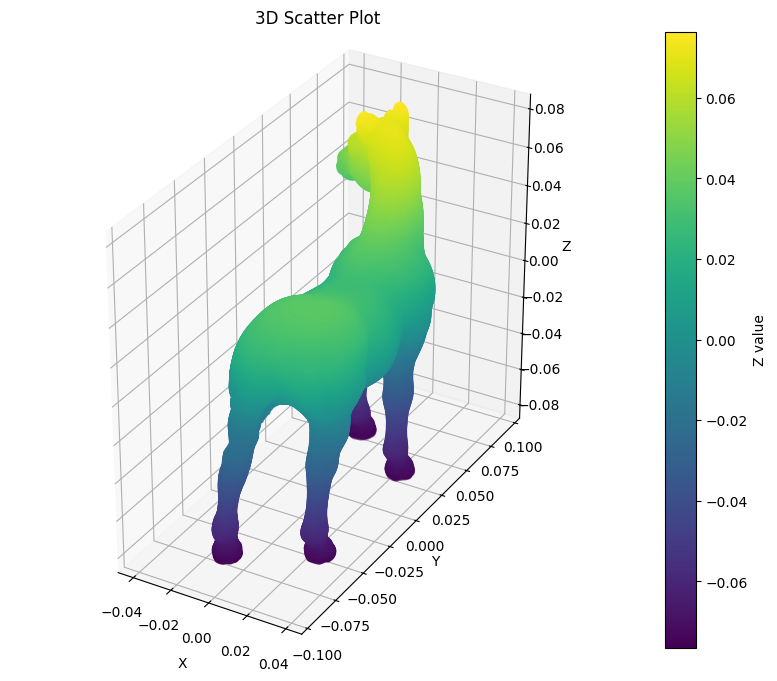

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter_from_df(df):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create the scatter plot
    scatter = ax.scatter(df['x'], df['y'], df['z'], c=df['z'], cmap='viridis')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot')

    # Add a color bar
    plt.colorbar(scatter, label='Z value')

    # Set aspect ratio to 'equal'
    ax.set_box_aspect((np.ptp(df['x']), np.ptp(df['y']), np.ptp(df['z'])))

    plt.show()

vectors = pd.DataFrame(df)

# Create the plot
plot_3d_scatter_from_df(vectors)

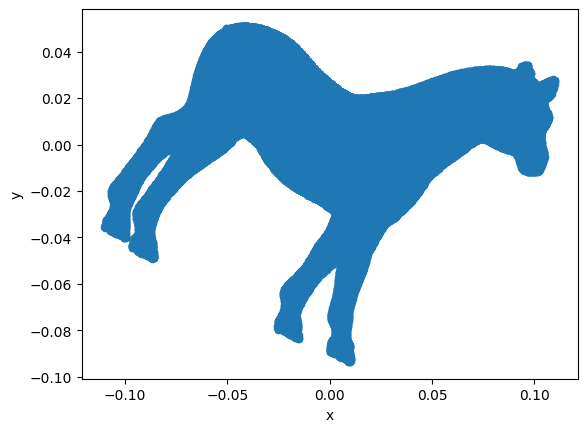

In [85]:
pca = PCA(n_components=2)
df2d = pd.DataFrame(pca.fit_transform(df), columns='x y'.split())
df2d.plot(kind='scatter', x='x', y='y')
plt.show()

## Latent Semantic Analysis

In [86]:
tfidf_docs.shape

(5000, 19160)

In [87]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=16, n_iter=100)
columns = ['topic{}'.format(i) for i in range(svd.n_components)]

svd_topic_vectors = svd.fit_transform(tfidf_docs)
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns, index=index)
svd_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
comment0,0.121,-0.055,0.036,-0.039,-0.033,-0.112,0.161,0.004,0.034,0.059,-0.064,0.013,-0.038,-0.088,0.014,-0.004
comment1,0.215,0.141,-0.007,-0.006,-0.035,-0.125,0.116,0.008,-0.109,0.021,0.168,-0.035,0.080,0.013,-0.054,-0.038
comment2,0.342,-0.200,0.046,-0.068,0.124,-0.162,-0.102,-0.038,-0.006,-0.051,0.106,0.060,-0.139,-0.025,0.058,0.036
comment3,0.130,-0.074,0.034,-0.016,0.048,-0.078,0.004,-0.072,-0.094,0.021,0.096,0.121,-0.059,-0.016,0.066,0.023
comment4!,0.166,-0.081,0.036,0.137,-0.033,0.025,-0.071,0.023,-0.005,-0.021,-0.019,0.066,-0.008,-0.063,-0.018,-0.006
comment5,0.257,-0.122,-0.057,0.080,0.068,-0.081,0.031,0.093,0.060,-0.009,-0.023,0.011,0.093,0.086,-0.066,-0.041


In [88]:
svd_topic_vectors.shape

(5000, 16)

Here we managed to reduce the dimension of the matrix from 19,169 (tokens) to 16 (topics).

In [89]:
list(tfidf_model.vocabulary_.items())[:5]

[('you', 18881),
 ('have', 8081),
 ('yet', 18859),
 ('to', 17074),
 ('identify', 8709)]

In [90]:
tfidf_model.vocabulary_

{'you': 18881,
 'have': 8081,
 'yet': 18859,
 'to': 17074,
 'identify': 8709,
 'where': 18437,
 'my': 11427,
 'edits': 6054,
 'violated': 18128,
 'policy': 13025,
 '.': 165,
 ' ': 16,
 '4': 878,
 'july': 9632,
 '2005': 680,
 '02:58': 240,
 '(': 124,
 'utc': 17841,
 ')': 126,
 '"': 80,
 '\n ': 1,
 'as': 2217,
 'i': 8657,
 'already': 1756,
 'said': 14799,
 ',': 131,
 'wp': 18725,
 ':': 1160,
 'rfc': 14486,
 'or': 12195,
 'ani': 1894,
 'talk→': 16630,
 '\xa0\xa0': 19031,
 '←track': 19104,
 'your': 18900,
 'vote': 18187,
 'on': 12108,
 'wikiquote': 18550,
 'simple': 15431,
 'english': 6266,
 'when': 18433,
 'it': 9388,
 'comes': 4186,
 'using': 17830,
 'sysop': 16544,
 'tools': 17122,
 'am': 1784,
 'not': 11808,
 'clueless': 4071,
 'because': 2701,
 'a': 1206,
 'site': 15478,
 'that': 16830,
 'is': 9339,
 'wikipedia': 18531,
 'tells': 16730,
 'me': 10797,
 'how': 8424,
 'use': 17797,
 'them': 16859,
 'understand': 17571,
 'being': 2743,
 'does': 5713,
 'make': 10579,
 'better': 2819,
 'tha

Sort the vocabulary by term count, ascending, then split them into indexes (`column_nums`) and `terms`

In [91]:
column_nums, terms = zip(*sorted(zip(tfidf_model.vocabulary_.values(), tfidf_model.vocabulary_.keys())))

In [92]:
topic_term_matrix = pd.DataFrame(svd.components_, columns=terms, index=['topic{}'.format(i) for i in range(svd.n_components)])

pd.options.display.max_columns = 8
topic_term_matrix.sample(5, axis='columns', random_state=271828).head(4)

,ᛏ,you;re,cruz,reached,chicago
topic0,0.000558,0.000208,0.000314,0.002004,0.000469
topic1,-0.000759,-0.000351,-0.000434,-0.000951,0.000315
topic2,-0.000354,-0.000005,-0.000398,-0.002873,-0.000539
topic3,0.000081,0.000104,-0.000024,-0.000006,0.000363


None of these words are toxic.

In [93]:
toxic_terms = topic_term_matrix[
    'pathetic crazy stupid idiot lazy hate die kill'.split()
].round(3) * 100 # multiple by 100 makes the weight easier to read
toxic_terms

,pathetic,crazy,stupid,idiot,lazy,hate,die,kill
topic0,0.3,0.1,0.7,0.6,0.1,0.4,0.2,0.2
topic1,-0.2,0.0,-0.1,-0.3,-0.1,-0.4,-0.1,0.1
topic2,0.7,0.1,1.1,1.7,-0.0,0.9,0.6,0.8
topic3,-0.2,0.0,0.0,0.1,0.1,0.0,0.0,0.2
topic4,0.7,0.2,1.3,1.5,0.3,1.8,0.7,0.0
topic5,0.4,0.2,0.7,1.9,0.1,-0.3,0.5,0.1
topic6,-0.2,-0.0,0.4,0.9,-0.1,0.1,0.9,-0.2
topic7,-0.2,-0.1,-0.1,-0.3,-0.1,-0.3,-0.3,0.2
topic8,0.0,-0.1,1.1,-0.6,-0.1,-0.7,0.1,-0.3
topic9,1.7,0.2,2.1,1.5,0.4,1.6,-0.7,0.7


In [94]:
toxic_terms.T.sum()

topic0     2.6
topic1    -1.1
topic2     5.9
topic3     0.2
topic4     6.5
topic5     3.6
topic6     1.8
topic7    -1.2
topic8    -0.6
topic9     7.5
topic10    1.0
topic11    4.0
topic12   -0.3
topic13   -1.7
topic14    4.2
topic15    1.5
dtype: float64

Topic 0, 2, 5, 9, 11, 14 tend to contain toxic contents. While topic 1, 7, 8, 12, 13 tend to be non-toxic.

In [95]:
X_train_16d, X_test_16d, y_train_16d, y_test_16d = train_test_split(svd_topic_vectors, comments.toxic.values, test_size=0.2, random_state=271828)

lda_lsa = discriminant_analysis.LinearDiscriminantAnalysis(n_components=1)
lda_lsa = lda_lsa.fit(X_train_16d, y_train_16d)

train_score = lda_lsa.score(X_train_16d, y_train_16d)
test_score = lda_lsa.score(X_test_16d, y_test_16d)

print('Train accuracy:', train_score)
print('Test accuracy:', test_score)

Train accuracy: 0.87825
Test accuracy: 0.892


Train accuracy dropped from 99%-ish to 87%, but resulted in higher test accuracy: 89% compared to TF-IDF.

In [96]:
from sklearn.metrics import precision_score, recall_score, f1_score
hparam_table = pd.DataFrame()
def hparam_rec(model, X_train, y_train, X_test, y_test, model_name, features):
    return {
        'classifier': model_name,
        'features': features,
        'train_accuracy': float(model.score(X_train, y_train)),
        'test_accuracy': float(model.score(X_test, y_test)),
        'test_precision': 
            precision_score(y_test, model.predict(X_test)),
        'test_recall':
            recall_score(y_test, model.predict(X_test)),
        'test_f1': f1_score(y_test, model.predict(X_test))
    }

In [97]:
lsa_performance = hparam_rec(lda_lsa, X_train_16d, y_train_16d, X_test_16d, y_test_16d, 'LDA', 'LSA (16 components)')
lsa_performance

{'classifier': 'LDA',
 'features': 'LSA (16 components)',
 'train_accuracy': 0.87825,
 'test_accuracy': 0.892,
 'test_precision': 0.6666666666666666,
 'test_recall': 0.272,
 'test_f1': 0.38636363636363635}

In [98]:
tfidf_performance = hparam_rec(lda_tfidf, X_train, y_train, X_test, y_test, 'tfidf', 'tokens')
tfidf_performance

{'classifier': 'tfidf',
 'features': 'tokens',
 'train_accuracy': 0.99875,
 'test_accuracy': 0.585,
 'test_precision': 0.12303664921465969,
 'test_recall': 0.3700787401574803,
 'test_f1': 0.18467583497053044}

In [99]:
hparam_table = pd.concat([hparam_table, 
                          pd.DataFrame([lsa_performance]), 
                          pd.DataFrame([tfidf_performance])], 
                         ignore_index=True)

In [100]:
hparam_table.T

,0,1
classifier,LDA,tfidf
features,LSA (16 components),tokens
train_accuracy,0.87825,0.99875
test_accuracy,0.892,0.585
test_precision,0.666667,0.123037
test_recall,0.272,0.370079
test_f1,0.386364,0.184676


In [101]:
from sklearn.model_selection import train_test_split

def evaluate_model(X, y, classifier, classifier_name, features):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=271828
    )
    classifier = classifier.fit(X_train, y_train)
    return hparam_rec(classifier, X_train, y_train, X_test, y_test, 
                      classifier_name, features)

## Latent Dirichlet allocation (LDiA)

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer(tokenizer = spacy_tokenize)
bow_docs = pd.DataFrame(counter.fit_transform(raw_documents=comments.text).toarray(), index=index)
bow_docs


/Users/hieu/miniconda3/envs/nlpia39/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,0,1,2,3,...,19156,19157,19158,19159
comment0,0,0,0,0,...,0,0,0,0
comment1,0,1,0,0,...,0,0,0,0
comment2,0,0,0,0,...,0,0,0,0
comment3,0,0,0,0,...,0,0,0,0
comment4!,0,0,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
comment4995,1,0,0,0,...,0,0,0,0
comment4996,0,0,0,0,...,0,0,0,0
comment4997!,1,0,0,0,...,0,0,0,0
comment4998!,1,0,0,0,...,0,0,0,0


In [103]:
column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys())))
bow_docs.columns = terms
bow_docs

,\n,\n,\n \n,\n \n,...,）,𒁳,🍁,😜
comment0,0,0,0,0,...,0,0,0,0
comment1,0,1,0,0,...,0,0,0,0
comment2,0,0,0,0,...,0,0,0,0
comment3,0,0,0,0,...,0,0,0,0
comment4!,0,0,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
comment4995,1,0,0,0,...,0,0,0,0
comment4996,0,0,0,0,...,0,0,0,0
comment4997!,1,0,0,0,...,0,0,0,0
comment4998!,1,0,0,0,...,0,0,0,0


In [104]:
comments.loc['comment0'].text

'you have yet to identify where my edits violated policy.  4 july 2005 02:58 (utc)'

In [105]:
bow_docs.loc['comment0'][bow_docs.loc['comment0'] > 0]

            1
(           1
)           1
.           1
02:58       1
2005        1
4           1
edits       1
have        1
identify    1
july        1
my          1
policy      1
to          1
utc         1
violated    1
where       1
yet         1
you         1
Name: comment0, dtype: int64

In [106]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA

lida = LDiA(n_components=16, learning_method='batch')
ldia = lida.fit(bow_docs)
lida.components_.shape

(16, 19160)

Number of terms: 19,160.

Number of topics: 16.

In [107]:
pd.set_option('display.width', 75)
columns = ['topic{}'.format(i) for i in range(ldia.n_components)]
term_topic_matrix = pd.DataFrame(lida.components_.T, index=terms, columns=columns)
term_topic_matrix

,topic0,topic1,topic2,topic3,...,topic12,topic13,topic14,topic15
\n,166.712896,61.255780,29.273680,21.524387,...,53.420413,0.0625,170.428543,1.604547
\n,0.763313,242.080168,7.810324,2.535852,...,4.221088,0.0625,34.489926,0.062500
\n \n,0.062501,2.468798,0.062500,0.062500,...,0.062500,0.0625,5.136006,0.062500
\n \n,0.062500,0.062500,0.062500,0.062500,...,0.062500,0.0625,4.062500,0.062500
\n,0.062500,1.931654,0.062500,0.062500,...,0.062500,0.0625,7.370494,0.062500
...,...,...,...,...,...,...,...,...,...
（,0.062500,0.062500,0.062500,0.062500,...,1.062500,0.0625,0.062500,0.062500
）,0.062500,0.062500,0.062500,0.062500,...,1.062500,0.0625,0.062500,0.062500
𒁳,0.062500,0.062500,0.062500,0.062500,...,0.062500,0.0625,0.062500,0.062500
🍁,0.062500,0.062500,0.062500,1.062500,...,0.062500,0.0625,0.062500,0.062500


In [108]:
toxic_terms = term_topic_matrix.loc['pathetic crazy stupid lazy idiot hate die kill'.split()]
toxic_terms

,topic0,topic1,topic2,topic3,...,topic12,topic13,topic14,topic15
pathetic,0.0625,0.06250,0.0625,0.062500,...,0.062500,0.062500,12.591582,0.062500
crazy,0.0625,0.06250,0.0625,0.062500,...,0.062500,0.062500,0.062500,0.062500
stupid,0.0625,3.25096,0.0625,5.643480,...,0.062500,0.062500,28.076879,2.699947
lazy,0.0625,0.06250,0.0625,0.062500,...,0.062500,0.062500,0.062500,0.062500
idiot,0.0625,0.06250,0.0625,4.069611,...,0.062500,0.062500,9.180837,0.062500
hate,0.0625,0.06250,0.0625,0.062500,...,0.062500,0.062500,0.062500,0.062500
die,0.0625,0.06250,0.0625,0.062500,...,0.066772,0.931356,0.062500,0.062500
kill,0.0625,0.06250,0.0625,0.062501,...,0.062500,0.062500,0.769427,1.062500


In [109]:
non_trivial_terms = [
    term for term in term_topic_matrix.index if term.isalpha() and len(term) > 3
]
non_trivial_terms[:5]

['aaaaaaaaaahhhhhhhhhhhhhh', 'aalst', 'aarem', 'aaron', 'abandoned']

In [110]:
term_topic_matrix.topic14.loc[non_trivial_terms].sort_values(ascending=False)

that         583.596462
your         525.971610
this         465.594401
have         447.659029
wikipedia    342.341559
                ...    
glow           0.062500
amritsar       0.062500
sieve          0.062500
micro          0.062500
obtains        0.062500
Name: topic14, Length: 15129, dtype: float64

In [111]:
lida16_topic_vectors = lida.transform(bow_docs)
lida16_topic_vectors = pd.DataFrame(lida16_topic_vectors, index=index, columns=columns)
lida16_topic_vectors

,topic0,topic1,topic2,topic3,...,topic12,topic13,topic14,topic15
comment0,0.003125,0.083507,0.003125,0.077950,...,0.003125,0.203189,0.597854,0.003125
comment1,0.002717,0.002717,0.002717,0.002717,...,0.002717,0.002717,0.502954,0.002717
comment2,0.000463,0.000463,0.000463,0.000463,...,0.000463,0.000463,0.993056,0.000463
comment3,0.003472,0.003472,0.003472,0.003472,...,0.003472,0.003472,0.947917,0.003472
comment4!,0.002604,0.002604,0.002604,0.002604,...,0.002604,0.002604,0.002604,0.002604
...,...,...,...,...,...,...,...,...,...
comment4995,0.000833,0.000833,0.000833,0.000833,...,0.000833,0.000833,0.000833,0.000833
comment4996,0.002604,0.002604,0.002604,0.002604,...,0.002604,0.002604,0.002604,0.002604
comment4997!,0.000539,0.000539,0.000539,0.000539,...,0.000539,0.000539,0.000539,0.000539
comment4998!,0.002083,0.002083,0.002083,0.002083,...,0.002083,0.002083,0.704524,0.002083


## Detect toxicity with LDiA

In [112]:
from sklearn import discriminant_analysis
model_lida16 = discriminant_analysis.LinearDiscriminantAnalysis()

lida16_performance = evaluate_model(lida16_topic_vectors, comments.toxic, model_lida16, 'LDA', 'LDIA (16 components)')
lida16_performance
hparam_table = pd.concat([hparam_table, pd.DataFrame([lida16_performance])], ignore_index=True)
hparam_table.T

,0,1,2
classifier,LDA,tfidf,LDA
features,LSA (16 components),tokens,LDIA (16 components)
train_accuracy,0.87825,0.99875,0.87
test_accuracy,0.892,0.585,0.8712
test_precision,0.666667,0.123037,0.52381
test_recall,0.272,0.370079,0.134969
test_f1,0.386364,0.184676,0.214634


In [113]:
lida32 = LDiA(n_components=32, learning_method='batch')
lida32 = lida32.fit(bow_docs)
model_lida32 = discriminant_analysis.LinearDiscriminantAnalysis()
columns32 = ['topic{}'.format(i) for i in range(lida32.n_components)]

lida32_topic_vectors = lida32.transform(bow_docs)
lida32_topic_vectors = pd.DataFrame(lida32_topic_vectors, index=index, columns=columns32)

lida32_performance = evaluate_model(lida32_topic_vectors, comments.toxic, model_lida32, 'LDA', 'LDIA (32d)')
hparam_table = pd.concat([hparam_table, pd.DataFrame([lida32_performance])], ignore_index=True)
hparam_table.T

,0,1,2,3
classifier,LDA,tfidf,LDA,LDA
features,LSA (16 components),tokens,LDIA (16 components),LDIA (32d)
train_accuracy,0.87825,0.99875,0.87,0.8748
test_accuracy,0.892,0.585,0.8712,0.8724
test_precision,0.666667,0.123037,0.52381,0.539326
test_recall,0.272,0.370079,0.134969,0.147239
test_f1,0.386364,0.184676,0.214634,0.231325


## Semantic search bot

In [116]:
url = 'https://gitlab.com/tangibleai/community/qary-cli/-/raw/main/src/qary/data/faq/short-faqs.csv'

df = pd.read_csv(url)
df

,question,answer
0,What kinds of data can a machine learning mode...,Machine learning models can only train on nume...
1,What are the basic variable data types in python?,"`float`, `int`, `str`, and `bool`"
2,What is a static model or distribution?,A probability distribution or model whose unde...
3,What is a leverage plot and what should I look...,I don't know.
4,What are replicants in the context of bootstra...,I don't know but I imagine they are the duplic...
...,...,...
67,What do I need to create a natural language pi...,You need a collection of texts labeled with wh...
68,Can I use a collection of YouTube comments to ...,Only if you have a numerical or categorical ra...
69,How can I count the number of records for a pa...,"`[(country, len(group)) for country, group df...."
70,What is a CDF (Cumulative Distribution Functio...,To estimate the probability or confidence inte...


In [138]:
vectorizer = TfidfVectorizer()
tfidfvectors = vectorizer.fit_transform(df['question'])

svd = TruncatedSVD(n_components=16, n_iter=100)
tfidfvectors_16d = svd.fit_transform(tfidfvectors)

def bot_reply(question):
    question_tfidf = vectorizer.transform([question]).toarray()
    question_16d = svd.transform(question_tfidf)
    idx = question_16d.dot(tfidfvectors_16d.T).argmax()

    print(
        f'Your question: {question}\n',
        f'Most simimilar question: {df["question"][idx]}\n',
        f'Answer: {df["answer"][idx]}\n'
    )

In [139]:
bot_reply('What is overfitting a mode?')

Your question: What is overfitting a mode?
 Most simimilar question: What is overfitting?
 Answer: When your test set accuracy is significantly lower than your training set accuracy.



In [140]:
bot_reply('How to decrease overfitting for Logistic Regression?')

Your question: How to decrease overfitting for Logistic Regression?
 Most simimilar question: How to reduce overfitting and improve test set accuracy for a LogisticRegression model?
 Answer: Decrease the C value, this increases the regularization strength.

